for discussion, refer to
https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/407972#2286191

In [1]:
import sys
sys.path.append('/kaggle/input/ink-00/my_lib')
sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')
sys.path.append('/kaggle/input/einops/einops-master')

from helper import *
import hashlib
import numpy as np
import pandas as pd

from collections import defaultdict
from glob import glob
import PIL.Image as Image
Image.MAX_IMAGE_PIXELS = 10000000000  # Ignore PIL warnings about large images

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder, DecoderBlock
from timm.models.resnet import *


import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
%matplotlib inline 
  
print('import ok !!!')

/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


import ok !!!


In [2]:
class Config(object):
    mode = [
        #'train', #
        'test', #'skip_fake_test',
    ]
    crop_fade  = 32
    crop_size  = 256
    crop_depth = 5
    infer_fragment_z = [16, 48]

CFG = Config()
CFG.rot_tta  = True #False #False #


if 'train' in CFG.mode:
    CFG.stride = CFG.crop_size//2 #56 #
if 'test' in CFG.mode:
    CFG.stride = CFG.crop_size//2
    CFG.rot_tta = True
 
def cfg_to_text():
    d = Config.__dict__
    text = [f'\t{k} : {v}' for k,v in d.items() if not (k.startswith('__') and k.endswith('__'))]
    d = CFG.__dict__
    text += [f'\t{k} : {v}' for k,v in d.items() if not (k.startswith('__') and k.endswith('__'))]
    return 'CFG\n'+'\n'.join(text)

print(cfg_to_text())

CFG
	mode : ['test']
	crop_fade : 32
	crop_size : 256
	crop_depth : 5
	infer_fragment_z : [16, 48]
	rot_tta : True
	stride : 128


In [3]:
## dataset ##
if 'train' in CFG.mode:
    data_dir = '/kaggle/input/vesuvius-challenge-ink-detection/train'
    valid_id =[
        '1',#'2b',
    ]

if 'test' in CFG.mode: 
    data_dir = '/kaggle/input/vesuvius-challenge-ink-detection/test'
    valid_id = glob(f'{data_dir}/*')
    valid_id = sorted(valid_id)
    valid_id = [f.split('/')[-1] for f in valid_id]

    # https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/410985
    a_file = f'{data_dir}/a/mask.png'
    with open(a_file,'rb') as f:
        hash_md5 = hashlib.md5(f.read()).hexdigest()
    is_skip_test = hash_md5 == '0b0fffdc0e88be226673846a143bb3e0'
    print('is_skip_test:',is_skip_test)

#---
print('data_dir', data_dir)
print('valid_id', valid_id)

def do_binarise(m, threshold=0.5):
    m = m-m.min()
    m = m/(m.max()+1e-7)
    m = (m>threshold).astype(np.float32)
    return m

def read_data(fragment_id, z0=CFG.infer_fragment_z[0], z1=CFG.infer_fragment_z[1]):
    volume = []
    start_timer = timer()
    for i in range(z0,z1):
        v = np.array(Image.open(f'{data_dir}/{fragment_id}/surface_volume/{i:02d}.tif'), dtype=np.uint16)
        v = (v >> 8).astype(np.uint8)
        #v = (v / 65535.0 * 255).astype(np.uint8)
        volume.append(v)
        print(f'\r @ read_data(): volume{fragment_id}  {time_to_str(timer() - start_timer, "sec")}', end='', flush=True)
    #print('')
    volume = np.stack(volume, -1)
    height, width, depth = volume.shape
    #print(f'fragment_id={fragment_id} volume: {volume.shape}')

    #---
    mask = cv2.imread(f'{data_dir}/{fragment_id}/mask.png',cv2.IMREAD_GRAYSCALE)
    mask = do_binarise(mask)

    if 'train' in CFG.mode:
        ir    = cv2.imread(f'{data_dir}/{fragment_id}/ir.png',cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(f'{data_dir}/{fragment_id}/inklabels.png',cv2.IMREAD_GRAYSCALE)
        ir    = ir/255
        label = do_binarise(label)

    if 'test' in CFG.mode:
        ir = None
        label = None

    d = dotdict(
        fragment_id = fragment_id,
        volume = volume,
        ir     = ir,
        label  = label,
        mask   = mask,
    )
    return d

def read_data1(fragment_id):
    if fragment_id=='2a':
        y = 9456
        d = read_data('2')
        d = dotdict(
            fragment_id='2a',
            volume  = d.volume[:y],
            ir      = d.ir[:y],
            label   = d.label[:y],
            mask    = d.mask[:y],
        )
    elif  fragment_id=='2b':
        y = 9456
        d = read_data('2')
        d = dotdict(
            fragment_id='2b',
            volume  = d.volume[y:],
            ir      = d.ir[y:],
            label   = d.label[y:],
            mask    = d.mask[y:],
        )
    elif  fragment_id=='2aa':
        y0,y1 = 0, 7074
        d = read_data('2')
        d = dotdict(
            fragment_id='2aa',
            volume  = d.volume[y0:y1],
            ir      = d.ir[y0:y1],
            label   = d.label[y0:y1],
            mask    = d.mask[y0:y1],
        )


    else:
        d = read_data(fragment_id)
    return d

def run_check_data():
    d=read_data1(valid_id[0])#valid_id[0]
    print('')
    print('fragment_id:', d.fragment_id)
    print('volume:', d.volume.shape, d.volume.min(), d.volume.max())
    print('mask  :', d.mask.shape, d.mask.min(), d.mask.max())
    if 'train' in CFG.mode:
        print('ir    :', d.ir.shape, d.ir.min(), d.ir.max())
        print('label :', d.label.shape, d.label.min(), d.label.max())

#run_check_data()
print('data ok !!!')

is_skip_test: True
data_dir /kaggle/input/vesuvius-challenge-ink-detection/test
valid_id ['a', 'b']
data ok !!!


running
batch
                          volume : torch.Size([3, 32, 256, 256]) 
                           label : torch.Size([3, 1, 256, 256]) 
output
                             ink : torch.Size([3, 1, 256, 256]) 
loss
/kaggle/input/ckpt-sue/Unet_fold1_slice16_crop_depth5_stride_64_best.pth
<All keys matched successfully>
CFG
	mode : ['test']
	crop_fade : 32
	crop_size : 256
	crop_depth : 5
	infer_fragment_z : [16, 48]
	rot_tta : True
	stride : 128

 @ read_data(): volumea   0 min 19 sec==================================
fragment_id a
	mask (2727, 6330)
	volume (2727, 6330, 32)
CFG.stride 128
CFG.crop_size 256

H,W,pH,pW,len(xy) 2727 6330 2816 6400 1029
 net[0] @infer_one(): 128 / 129 :  1 min 37 sec
probability (2727, 6330)

 @ read_data(): volumeb   0 min 37 sec==================================
fragment_id b
	mask (5454, 6330)
	volume (5454, 6330, 32)
CFG.stride 128
CFG.crop_size 256

H,W,pH,pW,len(xy) 5454 6330 5504 6400 2058
 net[0] @infer_one(): 257 / 258 :  3 min 14 sec
proba

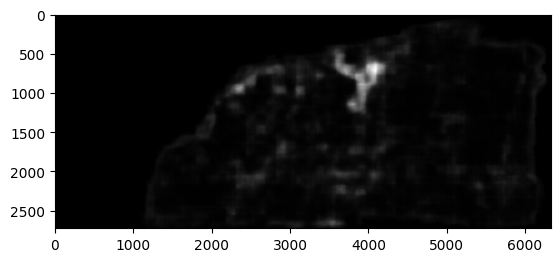

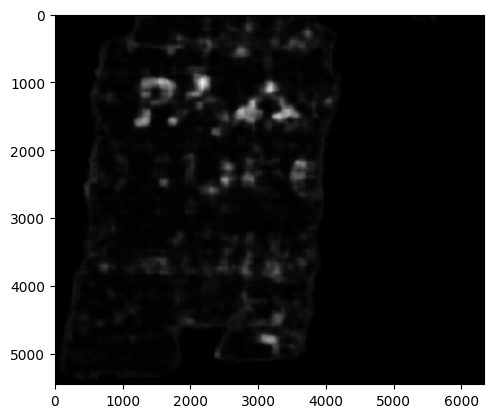

In [4]:
###### infer here !!!!

def make_infer_mask():
    s = CFG.crop_size
    f = CFG.crop_fade
    x = np.linspace(-1, 1, s)
    y = np.linspace(-1, 1, s)
    xx, yy = np.meshgrid(x, y)
    d = 1 - np.maximum(np.abs(xx), np.abs(yy))
    d1 = np.clip(d, 0, f / s * 2)
    d1 = d1 / d1.max()
    infer_mask = d1
    return infer_mask



def infer_one(net, d, batch_size=8):

    #get coord
    crop_size  = CFG.crop_size
    stride = CFG.stride
    H,W,D  = d.volume.shape

    ##pad #assume H,W >size
    px, py = W % stride, H % stride
    if (px != 0) or (py != 0):
        px = stride - px
        py = stride - py
        pad_volume = np.pad(d.volume, [(0, py), (0, px), (0, 0)], constant_values=0)
    else:
        pad_volume = d.volume

    pH, pW, _ = pad_volume.shape
    x = np.arange(0, pW - crop_size + 1, stride)
    y = np.arange(0, pH - crop_size + 1, stride)
    x, y = np.meshgrid(x, y)
    xy = np.stack([x, y], -1).reshape(-1, 2)
    print('H,W,pH,pW,len(xy)', H, W, pH, pW, len(xy))


    infer_mask = make_infer_mask()

    #----
    batch_iter = []
    for t in range(0,len(xy),batch_size):
        batch_iter.append(xy[t:t+batch_size])


    probability = np.zeros((pH,pW))
    count = np.zeros((pH,pW))

    num_net = len(net)
    for i in range(num_net):
        nnet = net[i].cuda()
        nnet = net[i].eval()

        #---
        start_timer = timer()
        for t, xy0 in enumerate(batch_iter):
            #print('\r', t, len(batch_iter), end='')

            volume =[]
            for x0,y0 in xy0 :
                v = pad_volume[y0:y0 + crop_size, x0:x0 + crop_size]
                volume.append(v)
            volume = np.stack(volume)
            volume = np.ascontiguousarray(volume.transpose(0,3,1,2))
            volume = volume/255
            volume = torch.from_numpy(volume).float().cuda()
            ##print(volume.shape)

            batch = { 'volume': volume }
            k = 0
            c = 0
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):

                    if not CFG.rot_tta:
                        output = nnet(batch['volume'])
                        k += output['ink'].data.cpu().numpy()
                        c += 1

                    #--
                    if CFG.rot_tta: #tta
                        pass
                        v = [
                            volume,
                            torch.rot90(volume, k=1, dims=(-2, -1)),
                            torch.rot90(volume, k=2, dims=(-2, -1)),
                            torch.rot90(volume, k=3, dims=(-2, -1)),
                        ]
                        K=len(v)
                        batch = {
                            'volume': torch.cat(v,0)
                        }
                        output = nnet(batch)
                        ink = output['ink']

                        B,_,h,w = volume.shape
                        ink = ink.reshape(K, B, 1, h, w)
                        ink = [
                            ink[0],
                            torch.rot90(ink[1], k=-1, dims=(-2, -1)),
                            torch.rot90(ink[2], k=-2, dims=(-2, -1)),
                            torch.rot90(ink[3], k=-3, dims=(-2, -1)),
                        ]
                        ink = torch.stack(ink, dim=0)
                        ink = ink.mean(0)

                        k += ink.data.cpu().numpy()
                        c += 1
                    #--
            k = k/c
            ##print(k.shape)
            for b in range(len(k)):
                x0,y0 = xy0[b]
                probability[y0:y0 + crop_size, x0:x0 + crop_size] += k[b,0]*infer_mask
                count[y0:y0 + crop_size, x0:x0 + crop_size] += infer_mask
            print(f'\r net[{i}] @infer_one(): {t} / {len(batch_iter)} : {time_to_str(timer() - start_timer, "sec")}', end='', flush=True)

    print('')
    probability = probability/(count+0.000001)
    probability = probability[:H,:W]
    probability = probability*d.mask
    return probability


######################################
import sys
sys.path.append('/kaggle/input/ink-00')
# from my_model_05 import Net as Resnet34
# from my_model_06 import Net as Resnet50

from my_model_07b import Net as Resnet34MeanPool

from my_model_07b import *
run_check_net()


######################################
if ('skip_fake_test' in CFG.mode) and (is_skip_test):
    submit_df = pd.DataFrame({
        'Id': valid_id,
        'Predicted':['1 2', '1 2']
    })
else:
    model = [
#[ Resnet34, '/kaggle/input/ink-weight-05/00015548.model.pth'],
#[ Resnet50, '/kaggle/input/ink-weight-05/00011952.model.pth'],
[ Resnet34MeanPool, '/kaggle/input/ckpt-sue/Unet_fold1_slice16_crop_depth5_stride_64_best.pth'],

]
 

    #----
    net = []
    for i,(Net,checkpoint) in enumerate(model):
        print(checkpoint)
        n = Net()
        f = torch.load(checkpoint, map_location=lambda storage, loc: storage)
        print(n.load_state_dict(f['model'], strict=False))  # True
        net.append(n)

    #----
    print(cfg_to_text())
    print('')
    submission = defaultdict(list)
    for t,fragment_id in enumerate(valid_id):
        d = read_data1(fragment_id)

        print('==================================')
        print('fragment_id', d.fragment_id)
        print('\tmask', d.mask.shape)
        print('\tvolume', d.volume.shape)
        print('CFG.stride', CFG.stride)
        print('CFG.crop_size', CFG.crop_size)  
        print('')

        probability = infer_one(net, d)
        print('probability', probability.shape)

        probability = d.mask*probability
        predict = (probability>0.55).astype(np.uint8)

        #----
        submission['Id'].append(fragment_id)
        submission['Predicted'].append(mask_to_rle(predict))

        #----
        probability8 = (probability * 255).astype(np.uint8)
        plt.figure(t), plt.imshow(probability8, cmap='gray')
        #plt.waitforbuttonpress()
        if 'train' in CFG.mode:
            text = metric_to_text(probability, d.label, d.mask)
            print(text)
        print('')

    print('')
    submit_df = pd.DataFrame.from_dict(submission)

print('')
print(cfg_to_text())
submit_df.to_csv('submission.csv', index=False)
print(submit_df)
print('submission.csv ok!!!')

 

In [5]:
'''
/kaggle/input/ink-weight-05/fold1-Resnet34MeanPool.00018924.model.pth
_IncompatibleKeys(missing_keys=['aux.0.weight', 'aux.0.bias', 'aux.1.weight', 'aux.1.bias', 'aux.2.weight', 'aux.2.bias', 'aux.3.weight', 'aux.3.bias', 'aux.4.weight', 'aux.4.bias'], unexpected_keys=[])
CFG
	valid_threshold : 0.8
	beta : 1
	crop_fade : 32
	crop_size : 256
	crop_depth : 5
	infer_fragment_z : [0, 32]
	dz : 0
	rot_tta : True
	stride : 64

 @ read_data(): volume1   0 min 49 sec==================================
fragment_id 1
	mask (8181, 6330)
	volume (8181, 6330, 32)
CFG.stride 64
CFG.crop_size 256

H,W,pH,pW,len(xy) 8181 6330 8192 6336 12000
 net[0] @infer_one(): 1499 / 1500 : 18 min 41 sec
probability (8181, 6330)
bce=0.19801
p_sum  th   prec   recall   fpr   dice   score
-----------------------------------------------
0.56, 0.10, 0.292, 0.898, 0.251,  0.441,  0.339
0.36, 0.20, 0.393, 0.763, 0.136,  0.518,  0.436
0.24, 0.30, 0.501, 0.650, 0.075,  0.566,  0.526
0.15, 0.40, 0.628, 0.524, 0.036,  0.571,  0.605
0.09, 0.50, 0.761, 0.388, 0.014,  0.514,  0.639
0.05, 0.60, 0.864, 0.244, 0.004,  0.381,  0.575
0.02, 0.70, 0.931, 0.099, 0.001,  0.179,  0.350
0.00, 0.80, 0.998, 0.012, 0.000,  0.023,  0.060
0.00, 0.90, 0.000, 0.000, 0.000,  0.000,  0.001



CFG
	valid_threshold : 0.8
	beta : 1
	crop_fade : 32
	crop_size : 256
	crop_depth : 5
	infer_fragment_z : [0, 32]
	dz : 0
	rot_tta : True
	stride : 64
  Id                                          Predicted
0  1  732898 4 732928 15 739227 7 739255 28 745555 1...
submission.csv ok!!!

'''

"\n/kaggle/input/ink-weight-05/fold1-Resnet34MeanPool.00018924.model.pth\n_IncompatibleKeys(missing_keys=['aux.0.weight', 'aux.0.bias', 'aux.1.weight', 'aux.1.bias', 'aux.2.weight', 'aux.2.bias', 'aux.3.weight', 'aux.3.bias', 'aux.4.weight', 'aux.4.bias'], unexpected_keys=[])\nCFG\n\tvalid_threshold : 0.8\n\tbeta : 1\n\tcrop_fade : 32\n\tcrop_size : 256\n\tcrop_depth : 5\n\tinfer_fragment_z : [0, 32]\n\tdz : 0\n\trot_tta : True\n\tstride : 64\n\n @ read_data(): volume1   0 min 49 sec==================================\nfragment_id 1\n\tmask (8181, 6330)\n\tvolume (8181, 6330, 32)\nCFG.stride 64\nCFG.crop_size 256\n\nH,W,pH,pW,len(xy) 8181 6330 8192 6336 12000\n net[0] @infer_one(): 1499 / 1500 : 18 min 41 sec\nprobability (8181, 6330)\nbce=0.19801\np_sum  th   prec   recall   fpr   dice   score\n-----------------------------------------------\n0.56, 0.10, 0.292, 0.898, 0.251,  0.441,  0.339\n0.36, 0.20, 0.393, 0.763, 0.136,  0.518,  0.436\n0.24, 0.30, 0.501, 0.650, 0.075,  0.566,  0.526